#### 서비스 기획
- 책의 표지나 책 속 문구를 사진 찍으면 해당 도서의 설명 페이지를 제공하는 서비스를 기획한다. 이를 위해 책의 제목이나 문구의 문자를 읽어들이는 ocr 프로그램을 만든다.

#### 서비스 목표
- 다양한 폰트로 작성된 책의 표지, 책 속 문구를 파악하고 문자를 읽어낸다.

In [1]:
import keras_ocr
import pytesseract

In [2]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


### Step1. 검증용 데이터셋 준비

In [3]:
image_urls = [
    # 교보문고 글판
    'https://mblogthumb-phinf.pstatic.net/MjAxNzEwMTdfNDIg/MDAxNTA4MjA3Njc0NDg2.jwz7EgRPo4CDq5_u2V97RSQS-1CuB0W560CxPLUarpsg.-renLjYrxrGXjBtspXjVgRjMXhJpvXyf0j8H96TzArwg.PNG.grubiz/%EC%8A%A4%ED%81%AC%EB%A6%B0%EC%83%B7_2017-10-17_%EC%98%A4%EC%A0%84_11.33.15.png?type=w800',
    'https://mblogthumb-phinf.pstatic.net/MjAxNzEwMTdfMjM3/MDAxNTA4MjA3Njc0NDcw.vSkRqLX1FUfjwf_JAAmRxE67sX3zWRd4TvfAUmadQg4g.m4cHV_71Ac_zRv6Cpj9tUFp_9vRUz1bHS9ZTd3_kRGkg.PNG.grubiz/%EC%8A%A4%ED%81%AC%EB%A6%B0%EC%83%B7_2017-10-17_%EC%98%A4%EC%A0%84_11.33.22.png?type=w800',
    'https://happist.com/files/attach/images/83/013/539/8114159a247672e92e15963aa574460e.jpg',
    'https://happist.com/files/attach/images/530/051/533/ecaf535641167362b34884703dc21b93.jpg',
    'https://img.khan.co.kr/news/c/320x220/2013/06/03/2013060301000188300021841.jpg'
]

### Step2. keras-ocr, Tesseract로 테스트 진행

### keras-ocr

In [4]:
images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

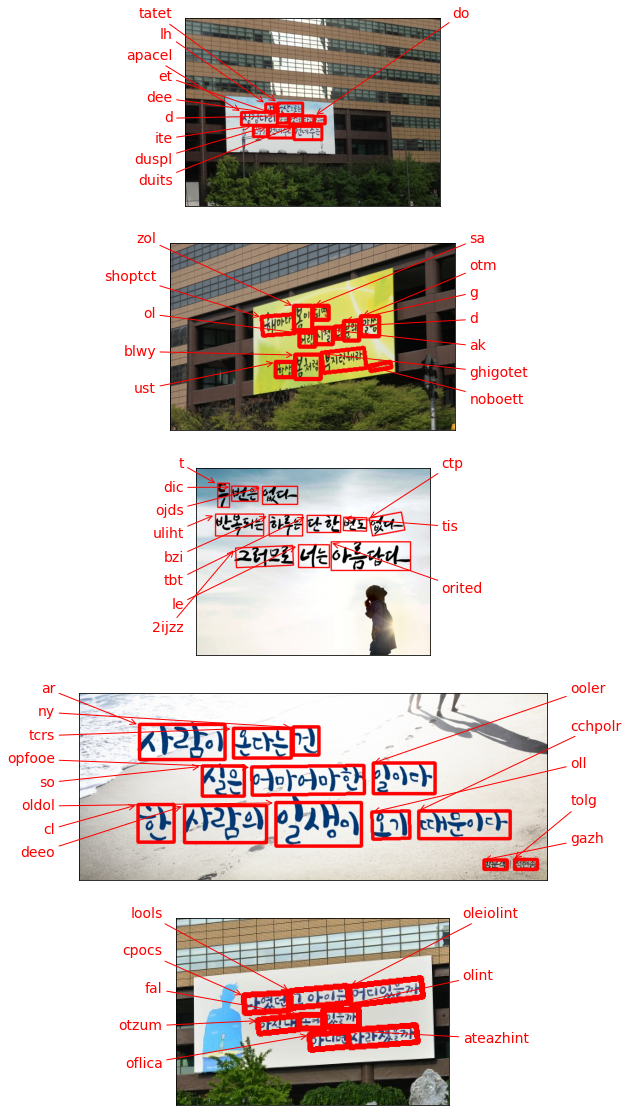

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

- keras-ocr은 한글 문자열을 영어로 인식하여 제대로 인식하지 못했다.

알파벳으로 이루어진 문자열

In [6]:
eng_urls = [
    'https://i.pinimg.com/originals/bf/11/ce/bf11ce0be8c4fdc69e65fd0e39eb1891.png',
    'https://assets.blog.engoo.com/wp-content/uploads/sites/2/2018/07/25022650/%EC%96%B4%EB%A6%B0%EC%99%95%EC%9E%90%EB%AA%85%EB%8C%80%EC%82%AC-3.jpg',
    'https://mblogthumb-phinf.pstatic.net/20150329_57/heejees_1427564254605j5hiP_JPEG/IMG_10386644978705.jpeg?type=w2',
    'https://i.pinimg.com/originals/56/7e/a4/567ea4f5cf24b2754ad6b39458bc0385.jpg',
    'https://i.pinimg.com/originals/72/4d/e5/724de5bdcafbb2f03aea8a8f2594869a.png'
]

In [7]:
images = [keras_ocr.tools.read(url) for url in eng_urls]
prediction_groups = [pipeline.recognize([url]) for url in eng_urls]

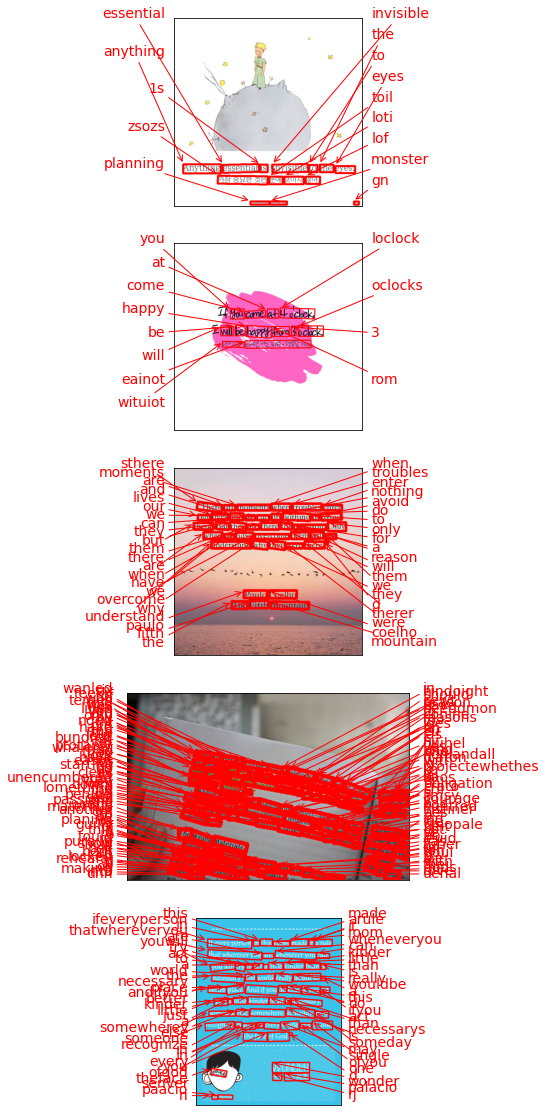

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### Tesseract

In [9]:
import os
import cv2
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path, output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
#             print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            if 0 in cropped_image.size:
                continue
                cropped_image.save(output_img_path)
                cropped_image_path_list.append(output_img_path)
                index += 1
    return cropped_image_path_list

In [10]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [11]:
# 교보문고 글판1

work_dir = os.getenv('HOME')+'/aiffel/ocr_python/samples/img1'
img1_file_path = work_dir + '/img1.png'

cropped_image1_path_list = crop_word_regions(img1_file_path, work_dir)

In [12]:
recognize_images(cropped_image1_path_list)

Done


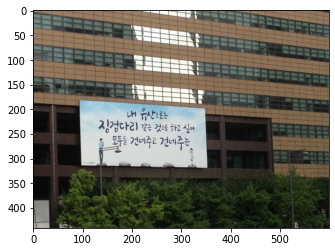

In [13]:
import cv2

img1 = cv2.imread(img1_file_path)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.show()

In [14]:
# 교보문고 글판2

work_dir = os.getenv('HOME')+'/aiffel/ocr_python/samples/img2'
img2_file_path = work_dir + '/img2.png'

cropped_image2_path_list = crop_word_regions(img2_file_path, work_dir)

In [15]:
recognize_images(cropped_image2_path_list)

Done


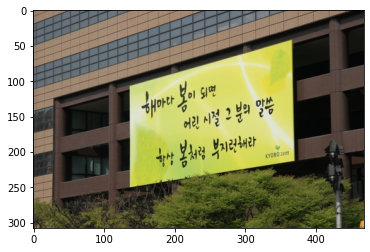

In [16]:
img2 = cv2.imread(img2_file_path)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2)
plt.show()

In [17]:
# 교보문고 글판3

work_dir = os.getenv('HOME')+'/aiffel/ocr_python/samples/img3'
img3_file_path = work_dir + '/img3.png'

cropped_image3_path_list = crop_word_regions(img3_file_path, work_dir)

In [18]:
recognize_images(cropped_image3_path_list)

Done


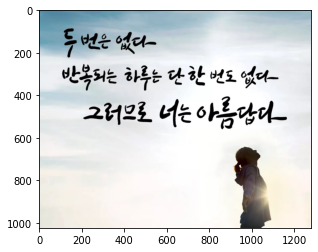

In [19]:
img3 = cv2.imread(img3_file_path)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
plt.imshow(img3)
plt.show()

In [20]:
# 교보문고 글판4

work_dir = os.getenv('HOME')+'/aiffel/ocr_python/samples/img4'
img4_file_path = work_dir + '/img4.png'

cropped_image4_path_list = crop_word_regions(img4_file_path, work_dir)

In [21]:
recognize_images(cropped_image4_path_list)

Done


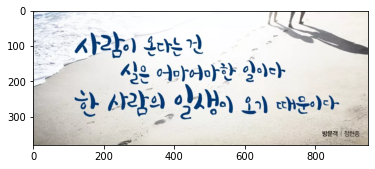

In [22]:
img4 = cv2.imread(img4_file_path)
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
plt.imshow(img4)
plt.show()

In [23]:
# 교보문고 글판5

work_dir = os.getenv('HOME')+'/aiffel/ocr_python/samples/img5'
img5_file_path = work_dir + '/img5.png'

cropped_image5_path_list = crop_word_regions(img5_file_path, work_dir)

In [24]:
recognize_images(cropped_image5_path_list)

Done


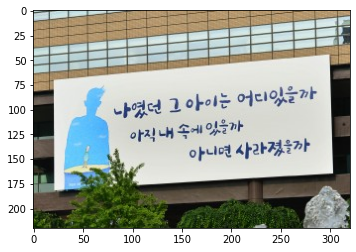

In [25]:
img5 = cv2.imread(img5_file_path)
img5 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)
plt.imshow(img5)
plt.show()

### Google OCR API

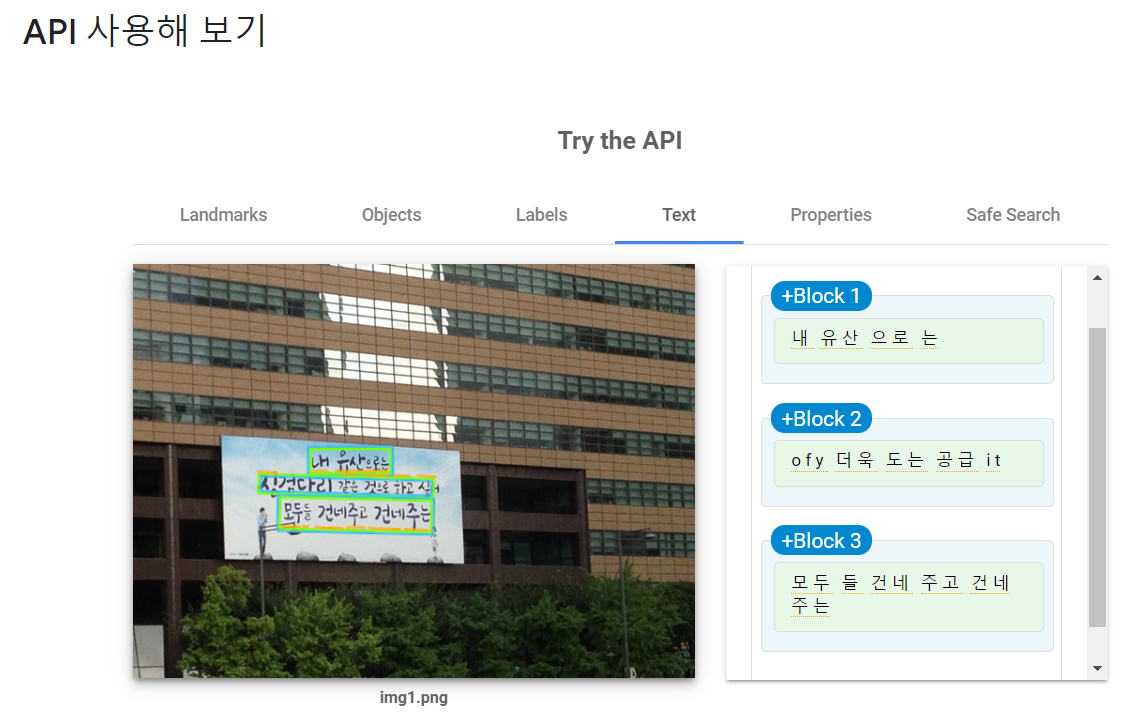

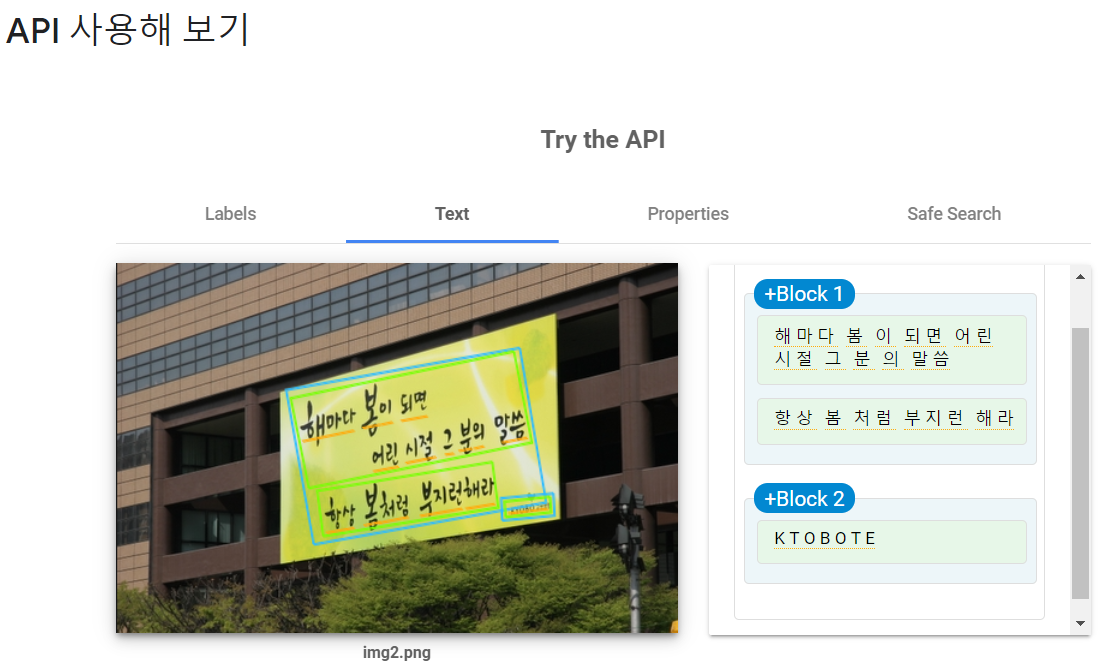

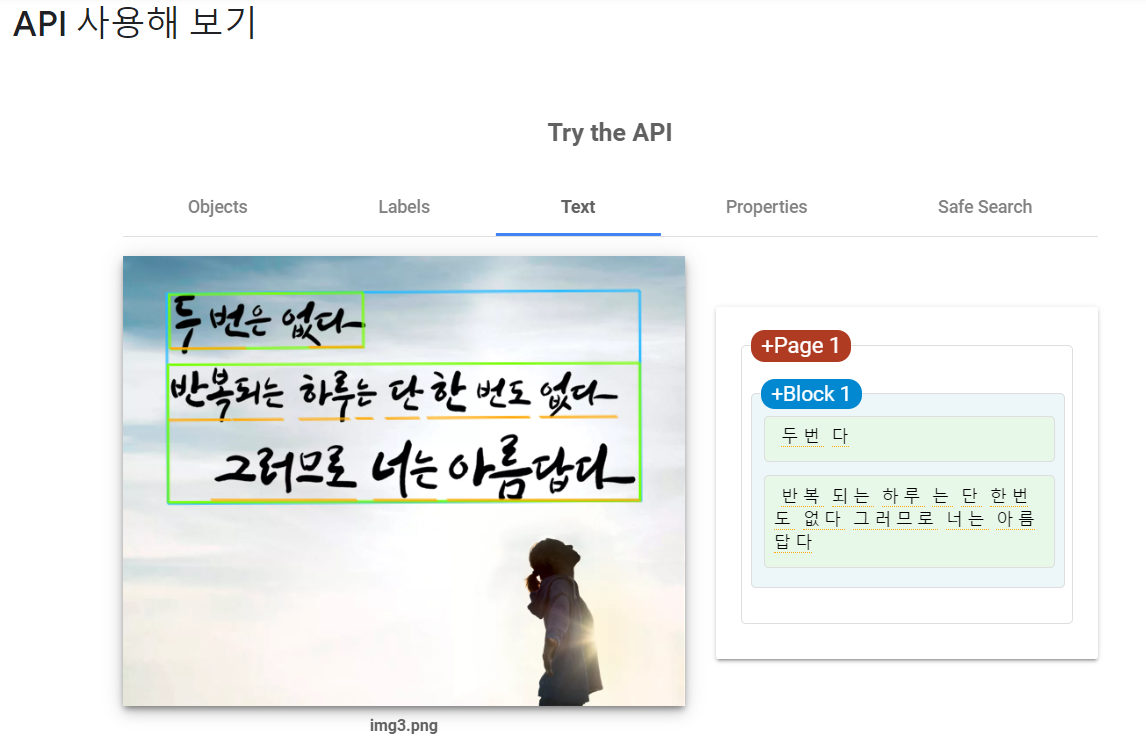

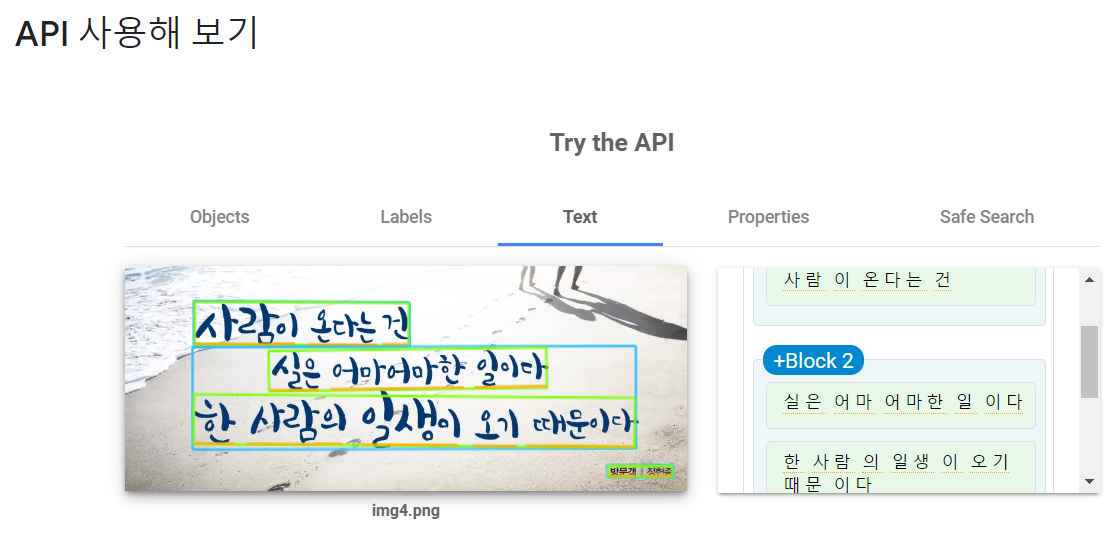

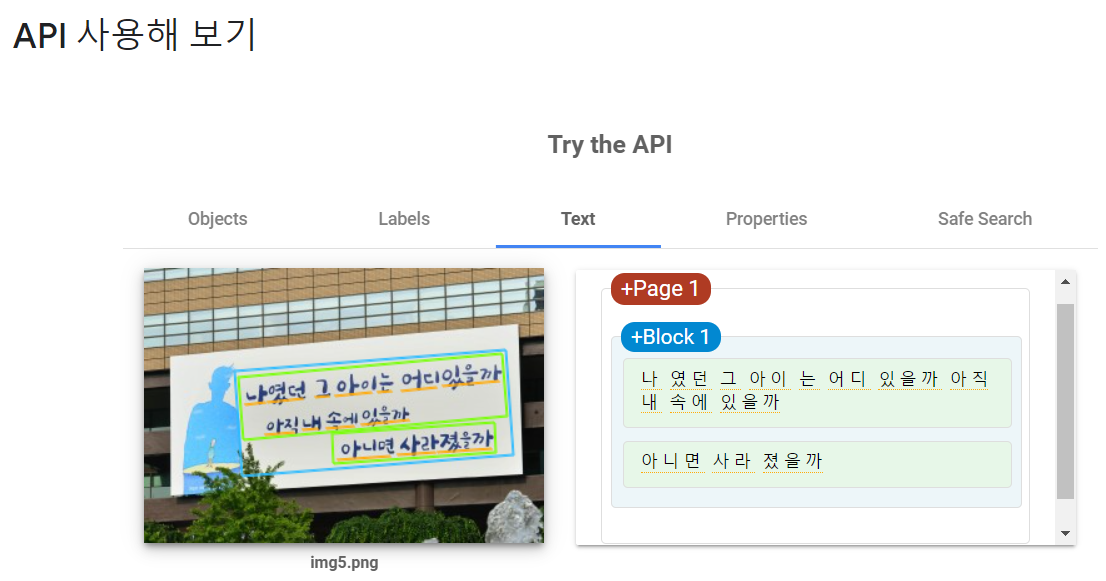

### Step3. 테스트 결과 정리

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-c3ow"></th>
    <th class="tg-c3ow">Keras-ocr</th>
    <th class="tg-c3ow">Tesseract</th>
    <th class="tg-c3ow">Google OCR API</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-c3ow">한국어 인식</td>
    <td class="tg-c3ow">X</td>
    <td class="tg-c3ow">O</td>
    <td class="tg-c3ow">O</td>
  </tr>
  <tr>
    <td class="tg-c3ow">정확도</td>
    <td class="tg-c3ow">보통</td>
    <td class="tg-c3ow">아주 낮음</td>
    <td class="tg-c3ow">높음</td>
  </tr>
  <tr>
    <td class="tg-c3ow">속도</td>
    <td class="tg-c3ow">아주 느림</td>
    <td class="tg-c3ow">느림</td>
    <td class="tg-c3ow">빠름</td>
  </tr>
</tbody>
</table>

#### Google OCR API > keras-ocr > Tesseract 순서로 성능이 좋았다.
- keras-ocr은 이미지의 한글 문자를 알파벳으로 인식하였고, 영어는 제대로 인식하지만 그 정확도가 조금 낮았다. 이미지를 문자로 바꾸는 과정이 오래 걸렸다.
- Tesseract은 한글을 인식하긴 하지만 정확도가 아주 낮다.
- Google OCR API는 한국어 인식에서는 거의 모든 글자를 인식하였다. 정확도도 높고 그 속도도 빨랐다.

### Step4. 결과 분석과 결론 제시

따라서 한국어를 대상으로 문자를 인식하여 데이터로 사용하려면 Goggle OCR API를 사용하는 것이 적절하다.

### 회고

- keras-ocr을 이용하면 한국어가 한글로 인식되지 않고 알파벳으로 인식되었다. 한국어를 ocr 기술을 이용하여 인식하고 싶었는데 keras-ocr은 한국어가 지원되지 않았고, Tesseract로는 한글이 제대로 출력되지 않았다. 

- Tesseract를 이용하여 이미지의 문자를 인식하려고 할 때 tile cannot extend outside image 에러가 떴다. https://jtrimind.github.io/troubleshooting/tile-cannot-extend-outside-image/ 에서 crop() 함수를 잘못 쓸 때 나타나는 오류이며 이미지의 크기가 (0,0)일 가능성이 높다고 하였다. 이미지 크기가 0일 때 저장하지 않도록 코드를 수정하면서 이미지 하나는 문자 출력되지 않았다.
    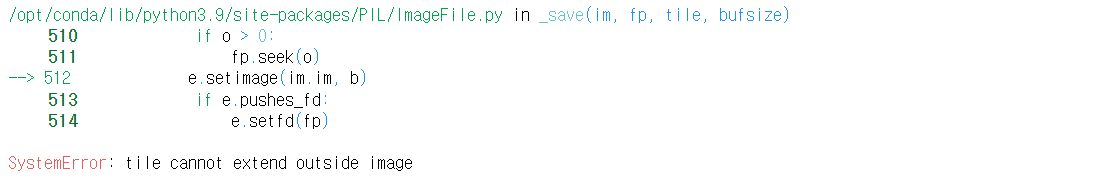

- keras-ocr의 문자 변환 속도를 줄일 수 있는 방법을 알고 싶다. 또한 Tesseract의 성능이 너무 안 좋게 나왔는데 어떻게 하면 성능을 높일 수 있는지 알고 싶다.